# Investigating how neuron treats swc files

**Load MSN class**

In [1]:
# %load MSN_builder.py
#
'''
The MSN class defining the cell
'''

from neuron import h
from math import exp
import json

# Distributions:
'''
T-type Ca: g = 1.0/( 1 +np.exp{(x-70)/-4.5} )
naf (den): (0.1 + 0.9/(1 + np.exp((x-60.0)/10.0)))

'''

def calculate_distribution(d3, dist, a4, a5,  a6,  a7, g8):
    '''
    Used for setting the maximal conductance of a segment.
    Scales the maximal conductance based on somatic distance and distribution type.
    
    Parameters:
    d3   = distribution type:
         0 linear, 
         1 sigmoidal, 
         2 exponential
         3 step function
    dist = somatic distance of segment
    a4-7 = distribution parameters 
    g8   = base conductance (similar to maximal conductance)
    
    '''
    
    if   d3 == 0: 
        value = a4 + a5*dist
    elif d3 == 1: 
        value = a4 + a5/(1 + exp((dist-a6)/a7) )
    elif d3 == 2: 
        value = a4 + a5*exp((dist-a6)/a7)
    elif d3 == 3:
        if (dist > a6) and (dist < a7):
            value = a4
        else:
            value = a5
            
    if value < 0:
        value = 0
        
    value = value*g8
    return value 

            
        

# ======================= the MSN class ==================================================

class MSN:
    def __init__(self,  params=None,                                \
                        morphology='latest_WT-P270-20-14ak.swc',    \
                        variables=None,                             \
                        SF = 1.0                                    ):
        Import = h.Import3d_SWC_read()
        Import.input(morphology)
        imprt = h.Import3d_GUI(Import, 0)
        imprt.instantiate(None)
        h.define_shape()
        # h.cao0_ca_ion = 2  # default in nrn
        h.celsius = 35
        self._create_sectionlists()
        self._set_nsegs()
        self.v_init = -80
        for sec in self.allseclist:
            sec.Ra = 150
            sec.cm = 1.0
            sec.insert('pas')
            #sec.g_pas = 1e-5 # set using json file
            sec.e_pas = -70 # -73
        for sec in self.somalist:
            sec.insert('naf')
            sec.insert('kaf')
            sec.insert('kas')
            sec.insert('kdr')
            sec.insert('kir')
            sec.ena = 50
            sec.ek = -85 # -90
            sec.insert('cal12')
            sec.insert('cal13')
            sec.insert('car')
            sec.insert('cadyn')
            sec.insert('caldyn')
            sec.insert('sk')
            sec.insert('bk')
            sec.insert('can')
        for sec in self.axonlist:
            sec.insert('naf')
            sec.insert('kas')
            sec.ena = 50
            sec.ek = -85 # -90
        for sec in self.dendlist:
            sec.insert('naf')
            sec.insert('kaf')
            sec.insert('kas')
            sec.insert('kdr')
            sec.insert('kir')
            sec.ena = 50
            sec.ek = -85 # -90
            sec.insert('cal12')
            sec.insert('cal13')
            sec.insert('car')
            sec.insert('cadyn')
            sec.insert('caldyn')
            sec.insert('sk')
            sec.insert('bk')
            sec.insert('cat32')
            sec.insert('cat33')

        with open(params) as file:
            par = json.load(file)

        self.distribute_channels("soma", "g_pas", 0, 1, 0, 0, 0, float(par['g_pas_all']['Value']))
        self.distribute_channels("axon", "g_pas", 0, 1, 0, 0, 0, float(par['g_pas_all']['Value']))
        self.distribute_channels("dend", "g_pas", 0, 1, 0, 0, 0, float(par['g_pas_all']['Value']))
        
        self.distribute_channels("soma", "gbar_naf", 0, 1, 0, 0, 0, SF*float(par['gbar_naf_somatic']['Value']))
        self.distribute_channels("soma", "gbar_kaf", 0, 1, 0, 0, 0, SF*float(par['gbar_kaf_somatic']['Value']))
        self.distribute_channels("soma", "gbar_kas", 0, 1, 0, 0, 0, SF*float(par['gbar_kas_somatic']['Value']))
        self.distribute_channels("soma", "gbar_kdr", 0, 1, 0, 0, 0, SF*float(par['gbar_kdr_somatic']['Value']))
        self.distribute_channels("soma", "gbar_kir", 0, 1, 0, 0, 0, SF*float(par['gbar_kir_somatic']['Value']))
        self.distribute_channels("soma", "gbar_sk",  0, 1, 0, 0, 0, SF*float(par['gbar_sk_somatic']['Value']))
        self.distribute_channels("soma", "gbar_bk",  0, 1, 0, 0, 0, SF*float(par['gbar_bk_somatic']['Value']))
        
        self.distribute_channels("axon", "gbar_naf", 3, 1, 1.1, 30, 500, float(par['gbar_naf_axonal']['Value']))
        self.distribute_channels("axon", "gbar_kas", 0, 1, 0, 0, 0,      float(par['gbar_kas_axonal']['Value']))
        
        if variables:
            self.distribute_channels("dend", "gbar_kaf", 1,   1, variables[0],  variables[1],  variables[2], float(par['gbar_kaf_basal']['Value']))
            self.distribute_channels("dend", "gbar_naf", 1, 1.0 - variables[3], variables[3], variables[4], variables[5], float(par['gbar_naf_basal']['Value']))
        else:
            self.distribute_channels("dend", "gbar_naf", 1, 0.1, 0.9,   60.0,   10.0, float(par['gbar_naf_basal']['Value']))
            self.distribute_channels("dend", "gbar_kaf", 1,   1, 0.5,  120.0,  -30.0, float(par['gbar_kaf_basal']['Value']))
        
        self.distribute_channels("dend", "gbar_kas", 2,   1, 9.0,  0.0, -5.0, float(par['gbar_kas_basal']['Value']))
        self.distribute_channels("dend", "gbar_kdr", 0, 1, 0, 0, 0, float(par['gbar_kdr_basal']['Value']))
        self.distribute_channels("dend", "gbar_kir", 0, 1, 0, 0, 0, float(par['gbar_kir_basal']['Value']))
        self.distribute_channels("dend", "gbar_sk",  0, 1, 0, 0, 0, float(par['gbar_sk_basal']['Value']))
        self.distribute_channels("dend", "gbar_bk",  0, 1, 0, 0, 0, float(par['gbar_bk_basal']['Value']))

        self.distribute_channels("soma", "pbar_cal12", 0, 1, 0, 0, 0, SF*1e-5)
        self.distribute_channels("soma", "pbar_cal13", 0, 1, 0, 0, 0, SF*1e-6)
        self.distribute_channels("soma", "pbar_car",   0, 1, 0, 0, 0, SF*1e-4)
        self.distribute_channels("soma", "pbar_can",   0, 1, 0, 0, 0, SF*3e-5)
        self.distribute_channels("dend", "pbar_cal12", 0, 1, 0, 0, 0, 1e-5)
        self.distribute_channels("dend", "pbar_cal13", 0, 1, 0, 0, 0, 1e-6)
        self.distribute_channels("dend", "pbar_car",   0, 1, 0, 0, 0, 1e-4)
        self.distribute_channels("dend", "pbar_cat32", 1, 0, 1.0, 120.0, -30.0, 1e-7)
        self.distribute_channels("dend", "pbar_cat33", 1, 0, 1.0, 120.0, -30.0, 1e-8)

    def _create_sectionlists(self):
        self.allsecnames = []
        self.allseclist = h.SectionList()
        for sec in h.allsec():
            self.allsecnames.append(sec.name())
            self.allseclist.append(sec=sec)
        self.nsomasec = 0
        self.somalist = h.SectionList()
        for sec in h.allsec():
            if sec.name().find('soma') >= 0:
                self.somalist.append(sec=sec)
                if self.nsomasec == 0:
                    self.soma = sec
                self.nsomasec += 1
        self.axonlist = h.SectionList()
        for sec in h.allsec():
            if sec.name().find('axon') >= 0:
                self.axonlist.append(sec=sec)
        self.dendlist = h.SectionList()
        for sec in h.allsec():
            if sec.name().find('dend') >= 0:
                self.dendlist.append(sec=sec)

    def _set_nsegs(self):
        for sec in self.allseclist:
            sec.nseg = 2*int(sec.L/40.0)+1
        for sec in self.axonlist:
            sec.nseg = 2  # two segments in axon initial segment

    def _max_dist(self, axon_excluding=True):
        '''find maximal dendritic branch length''' 
        h.distance(sec=self.soma)
        dmax = 0
        for sec in self.allseclist:
	        if axon_excluding and sec.name().find('axon') == 0: continue
                dmax = max(dmax, h.distance(1, sec=sec))
        return dmax

    def distribute_channels(self, as1, as2, d3, a4, a5, a6, a7, g8):
        h.distance(sec=self.soma)
        dmax = self._max_dist()
        
        for sec in self.allseclist:
            
            # if right cellular compartment (axon, soma or dend)
            if sec.name().find(as1) >= 0:
                for seg in sec:
                    dist = h.distance(seg.x, sec=sec)
                    val = calculate_distribution(d3, dist, a4, a5, a6, a7, g8)
                    cmd = 'seg.%s = %g' % (as2, val)
                    exec(cmd)


**load main script**

In [1]:
%%writefile display_topology.py
from __future__ import print_function, division
#from mpi4py import MPI
from neuron import h
#from neuron import gui
#pc = h.ParallelContext()
#id = int(pc.id())
import numpy                as np
import MSN_builder          as build
import glob
import pickle



h.load_file('stdlib.hoc')
h.load_file('import3d.hoc')



# D1
D1_params  =   [[0.5739438400147591, 114.46525970607432, -24.778683242914425, 0.9656307062939439, 40.55882910975278, 4.924556428134727],    \
                [0.6486015000884895, 37.19526177848555, -51.44257878295532, 0.9199040036041007, 38.773590273202544, 4.138269856798566],     \
                [0.34835213066115794, 92.06973911679478, -13.043854781662562, 0.9812668369096036, 35.31855413027535, 4.764644405812756],    \
                [0.8115471666044635, 44.7944466983775, -51.05269981676671, 0.9310487434283193, 40.02623282398899, 3.698685454575806],       \
                [0.5009368290963206, 26.47283142378077, -40.15544309999925, 0.9376314551458907, 34.918864668708565, 5.689649054327928],     \
                [0.11337316688781601, 74.85203079871395, -37.663738588683266, 0.9791107718457724, 40.313411748972555, 1.7599610703626931],  \
                [0.7178317755261724, 55.78999694946826, -40.594540879418844, 0.934360843812911, 24.039770691171, 11.85002736955439],        \
                [0.7084541798016345, 60.5127880861534, -55.54871428461576, 0.9063982542677244, 44.50455979565052, 1.2727982786963663],      \
                [0.6035708031273619, 46.80870702319583, -64.09248569745006, 0.9280326409654382, 37.58186874484719, 2.729291505716056],      \
                [0.561072695250727, 30.279814655445957, -5.915582850103075, 0.9240749040725246, 47.175148898308336, 3.9786457316868438],    \
                [0.7084541798016345, 60.5127880861534, -55.54871428461576, 0.9063982542677244, 44.50455979565052, 1.2727982786963663] ]

# D2
D2_params  =   [[0.36519026711426983, 85.9950693571762, -29.308683882971575, 0.9148525825598594, 31.715617529156468, 14.265211741761483],   \
                [0.16856005736302448, 126.23264636214776, -24.844746770683354, 0.9321044414025511, 30.258105136928478, 16.71932312947103],  \
                [0.8998189135933885, 119.36936307317013, -46.95178922978055, 0.8971817650810714, 33.820535805627614, 13.259594919674436],   \
                [0.3212471483859052, 73.2110386772533, -21.537721797784236, 0.9086172801642267, 36.981483525375666, 10.22848048793786],     \
                [0.5820977302857862, 57.946759035757786, -18.187141446438467, 0.8928497341805598, 46.779147877476554, 11.121000433080683],  \
                [0.46297432359551316, 54.020547269954754, -41.038717738089424, 0.9112928426829239, 23.74013590665613, 21.09496685904177],   \
                [0.20862895117356128, 14.373675087979382, -69.54059375795693, 0.9336951592433631, 43.40456122099932, 15.291555103979722],   \
                [0.42405610469134825, 2.083973089688305, -64.58731908139677, 0.9006809103056398, 31.54569527007518, 11.894971817963789],    \
                [0.2935952963686902, 84.25383011698389, -43.048666783931345, 0.9299719258473008, 42.89522927693975, 14.821301506581849],    \
                [0.813828871477326, 84.51778812354367, -22.93434820961655, 0.9024356980563085, 36.356176317731936, 16.866648293828433] ]
    



def save_vector(t, v, outfile):
    
    with open(outfile, "w") as out:
        for time, y in zip(t, v):
            out.write("%g %g\n" % (time, y))                     
 
        
        
        
def main(par="./params_iMSN.json",                  \
                            sim='plateau',          \
                            amp=0.265,              \
                            run=None,               \
                            simDur=7000,            \
                            stimDur=900,            \
                            distParams=None,        \
                            cell_type='D2',         \
                            morphology='WT-P270-09-14ak_iMSN.swc',  \
                            SF=1.0,                 \
                            somaCond=False,         \
                            printDend=False,        \
                            section=None,           ): 
    
    
    
    
    #print(cell_type, morphology, par, section, run)
    
    
    if distParams:
        # load best fit parameters
        random_variables = distParams
    else:
        # draw random parameters
        random_variables = [    np.random.uniform(0.1,0.9), \
                                np.random.uniform(1,130),   \
                                np.random.uniform(-3,-70),  \
                                np.random.uniform(0.0,1.0), \
                                np.random.uniform(20,50),   \
                                np.random.uniform(1,50)     ]
        
        
    # initiate cell
    cell = build.MSN(  params=par,                  \
                       morphology=morphology,       \
                       variables=random_variables,  \
                       SF=SF                        )
    
    
    # set cascade--not connected to channels in this script, 
    # but used for setting pointers needed in the channel mechnisms
    casc    =   h.D1_reduced_cascade2_0(0.5, sec=cell.soma) 
    pointer =   casc._ref_Target1p    
       
    
    # set edge of soma as reference for dendritic distance 
    h.distance(1, sec=h.soma[0])
    
    
    # set current injection
    stim        =   h.IClamp(0.5, sec=cell.soma)
    stim.amp    =   amp  
    stim.delay  =   100
    stim.dur    =   stimDur    
     
    
    # record vectors
    tm  = h.Vector()
    tm.record(h._ref_t)
    vm  = h.Vector()
    vm.record(cell.soma(0.5)._ref_v)
    
    tstop       = simDur 
    # dt = default value; 0.025 ms (25 us)
                  
    
    # set pointers; need since same mechanisms are used for dynamic modulation of channels.
    # Modulation of channels is not used in this script
    for sec in h.allsec():
        
        for seg in sec:
            
            
            # naf and kas is in all sections
            h.setpointer(pointer, 'pka', seg.kas )
            h.setpointer(pointer, 'pka', seg.naf )
            
            if sec.name().find('axon') < 0:    
                
                
                # these channels are not in the axon section
                h.setpointer(pointer, 'pka', seg.kaf )
                h.setpointer(pointer, 'pka', seg.cal12 )
                h.setpointer(pointer, 'pka', seg.cal13 )
                h.setpointer(pointer, 'pka', seg.kir )
                
                if sec.name().find('soma') >= 0:
                    
                    
                    # N-type Ca (can) is only distributed to the soma section
                    h.setpointer(pointer, 'pka', seg.can )
            
    
    h.finitialize(cell.v_init)
    
    # print morph and cond parameters
    somaChan  = ['naf', 'kas', 'kaf', 'kir', 'cal12', 'cal13', 'can']
    dend_name = 'dend[' + str(int(section)) + ']'
    
    area      = 0.0
    axon_a    = 0.0  
    ik        = 0.0
    ina       = 0.0
    ica       = 0.0
    ical      = 0.0
    
    if printDend:
        if len( morphology.split('/') ) > 1:
            log = open("../m_dend_org.txt", "w")
        else:
            log = open("../m_dend_new.txt", "w")
            
    
    print( '--------------------' )
    for sec in h.allsec():
        
        if sec.name().find('soma') >= 0:
            print( sec.name(), 'len', sec.L )
            #print( dir(sec) )
            #print( sec.L )
            
            for seg in sec:
                if not somaCond:
                    #print( dir(seg) )
                    print('x', seg.x )
                    print('diam', seg.diam )
                    print('area', seg.area() )
                    area += float( seg.area() )
                    print('acum area', area )
                    print('Ra',  seg.ri() )
                    print('dist', h.distance(seg.x, sec=sec) )
                    print( '-----' )
                else:
                    
                    ik += float( seg.ik * seg.area() )
                    print('acum ik', ik)
                    ina += float( seg.ina * seg.area() )
                    print('acum ina', ina)
                    ica += float( seg.ica * seg.area() )
                    print('acum ica', ica )
                    ical += float( seg.ical * seg.area() )
                    print(ical )
                    area += float( seg.area() )
                    print('acum area', area )
                    print( '-----' )
                    
                
            print( '--------------------' )
        
        elif sec.name().find('axon') >= 0:
            print( sec.name(), sec.L )
            #print( dir(sec) )
            #print( sec.L )
            
            for seg in sec:
                if not somaCond:
                    #print( dir(seg) )
                    print('x', seg.x )
                    print('diam', seg.diam )
                    print('area', seg.area() )
                    axon_a += float( seg.area() )
                    print('acum area', axon_a )
                    print('Ra',  seg.ri() )
                    print('dist', h.distance(seg.x, sec=sec) )
                    print( '-----' )
                
            print( '--------------------' )
            
        elif sec.name().find('dend') >= 0:
            if printDend:
                for seg in sec:
                    print( sec.name(), seg.x, h.distance(seg.x, sec=sec), file=log )
                
    print('soma', area )
    print('axon', axon_a )
    
    
    
    #print( dir(h) )
    #print( dir(h.PlotShape) )
    if somaCond:
        print()
        print('total soma current')
        print(ik+ina+ica+ical)
        print()
    elif printDend:
        log.close()
    else:
        s = h.PlotShape()
        s.show(0)
        #s.fastflush()
        size = 180
        # .view(mleft, mbottom, mwidth, mheight, sleft, stop, swidth, sheight)
        #s.view(-size, -size, size*2,size*2, 500, 500, 1500, 1500)
        s.size(-size, size, -size, size)
        #s.variable("v")
        s.scale(-85, -20)
        #s.point_mark(2, "O", 10, sec=point)
        #s.color(2, sec=point) # color section "a" red
        s.exec_menu("Shape Plot")
        frame=morphology.split('.')[0].split('_')[1]
        s.printfile("fig_"+frame+".ps")
    
    
      
            


Writing display_topology.py


## Sperical soma (1 node), 1 dendrite and 1 axon segment

**write morphology with spherical soma**

In [8]:
%%writefile m1_spherical.swc
1 1   0   0    0  6.1  -1
2 3 100   0    0  0.5   1
3 3 150   0    0  0.5   2
4 2   0  30    0  0.5   1
5 2   0  60    0  0.5   4

Writing m1_spherical.swc


**load and plot in NEURON**

In [9]:
cell_type   =   'D1'
par         =   './params_dMSN.json'
morphology  =   'm1_spherical.swc'
parameters  =   D1_params
N           =   30
norm_val    =   0


main(   par=par,                    \
        morphology=morphology,      \
        run=0,                      \
        amp=0,                      \
        simDur=500,                 \
        stimDur=800,                \
        sim='plateau',              \
        section=5,                  \
        cell_type=cell_type,        \
        distParams=parameters[0]    )

--------------------
soma[0] len 12.1999998093
x 0.5
diam 12.1999998093
area 467.59463594
acum area 467.59463594
Ra 0.0782729240558
dist 6.09999990463
-----
--------------------
axon[0] 30.0
x 0.25
diam 1.0
area 47.1238898038
acum area 47.1238898038
Ra 14.3239448783
dist 13.5999999046
-----
x 0.75
diam 1.0
area 47.1238898038
acum area 94.2477796077
Ra 28.6478897565
dist 28.5999999046
-----
--------------------
soma 467.59463594
axon 94.2477796077


**Load resulting ps figure**

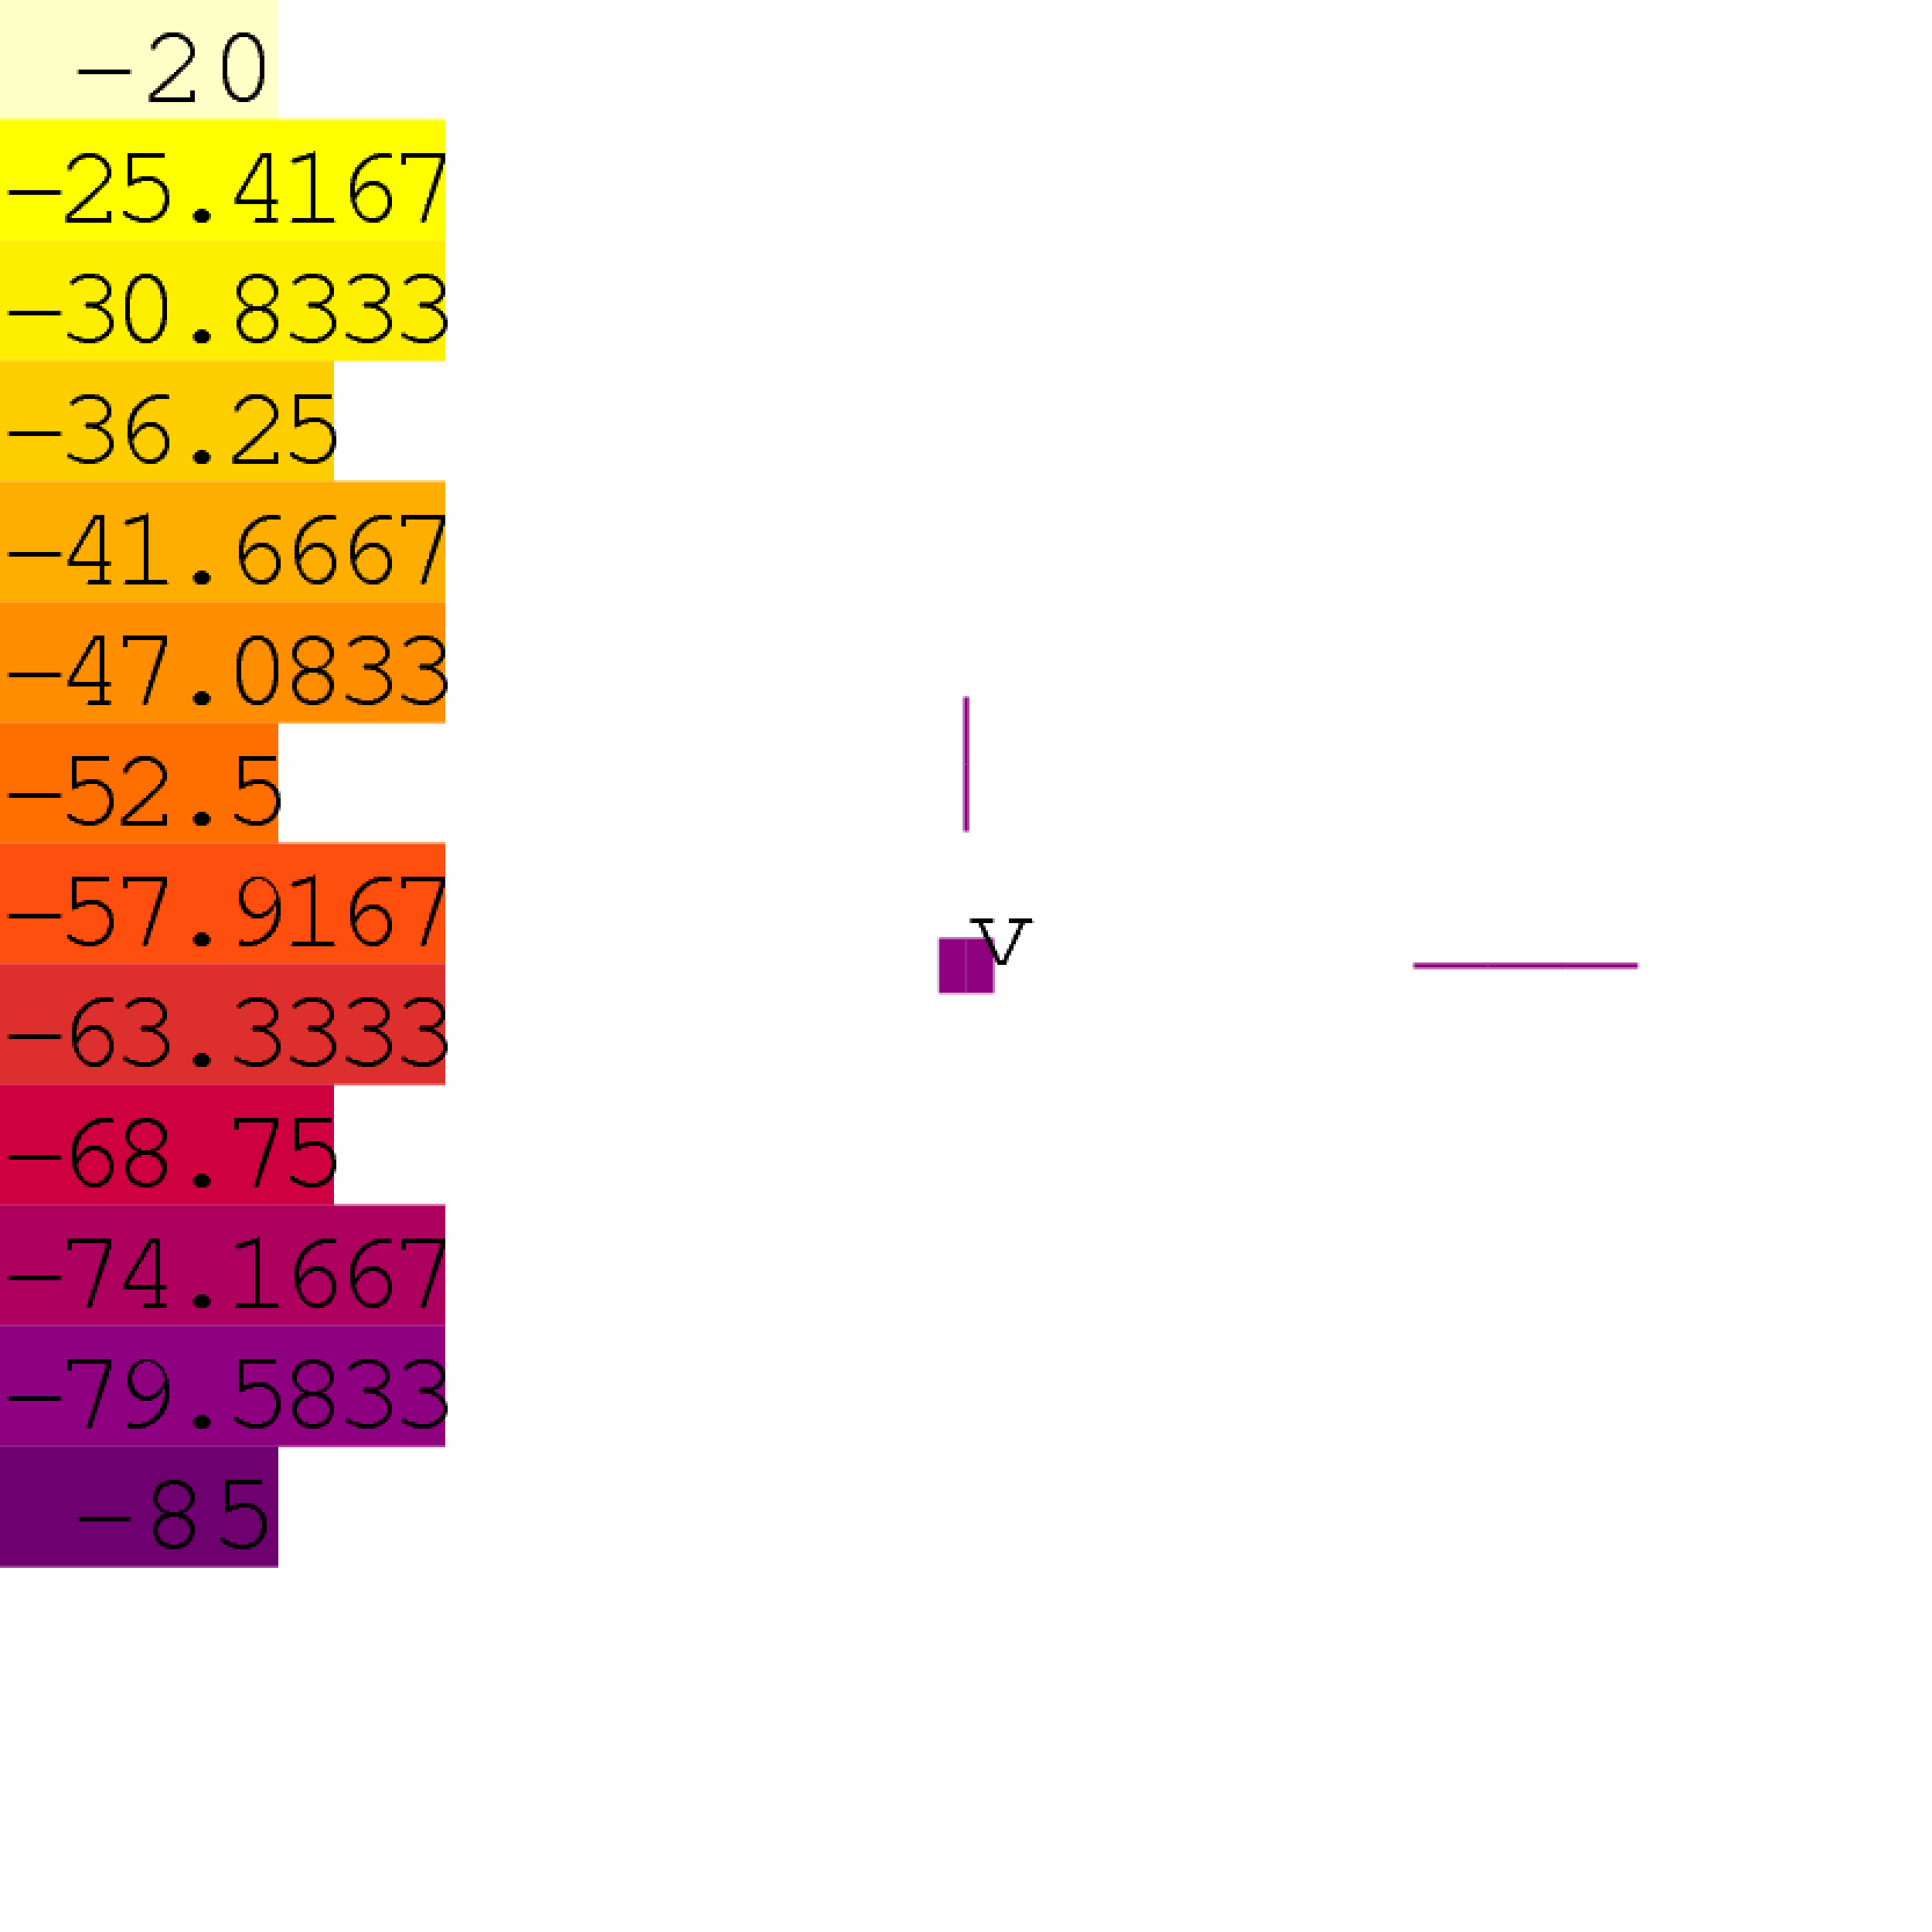

In [10]:
!convert -density 300 'fig_spherical.ps' -scale '300%' 'fig_spherical.png'
from IPython.display import Image
Image(filename='fig_spherical.png', width=300)

## 3-point soma (cylinder)

### connected to the first node

**write morphology with cylindrical soma**

In [11]:
%%writefile m1_cylinder1.swc
1 1   0   0    0    5.6  -1
2 1   0   0    5.6  5.6   1
3 1   0   0   12.2  5.6   2
4 3 100   0    0    0.5   1
5 3 150   0    0    0.5   4
6 2   0  30    0    0.5   1
7 2   0  60    0    0.5   6

Writing m1_cylinder1.swc


**run**

In [12]:
cell_type   =   'D1'
morphology  =   'm1_cylinder1.swc'

main(   par=par,                    \
        morphology=morphology,      \
        run=0,                      \
        amp=0,                      \
        simDur=500,                 \
        stimDur=800,                \
        sim='plateau',              \
        section=5,                  \
        cell_type=cell_type,        \
        distParams=parameters[0]    )

--------------------
soma[0] len 11.1999998093
x 0.5
diam 11.1999998093
area 394.081369044
acum area 394.081369044
Ra 0.0852615781084
dist 5.59999990463
-----
--------------------
soma[1] len 6.59999990463
x 0.5
diam 11.1999998093
area 232.226521643
acum area 626.307890687
Ra 0.0502434300864
dist 8.89999985695
-----
--------------------
axon[0] 30.0
x 0.25
diam 1.0
area 47.1238898038
acum area 47.1238898038
Ra 14.3239448783
dist 13.0999999046
-----
x 0.75
diam 1.0
area 47.1238898038
acum area 94.2477796077
Ra 28.6478897565
dist 28.0999999046
-----
--------------------
soma 626.307890687
axon 94.2477796077


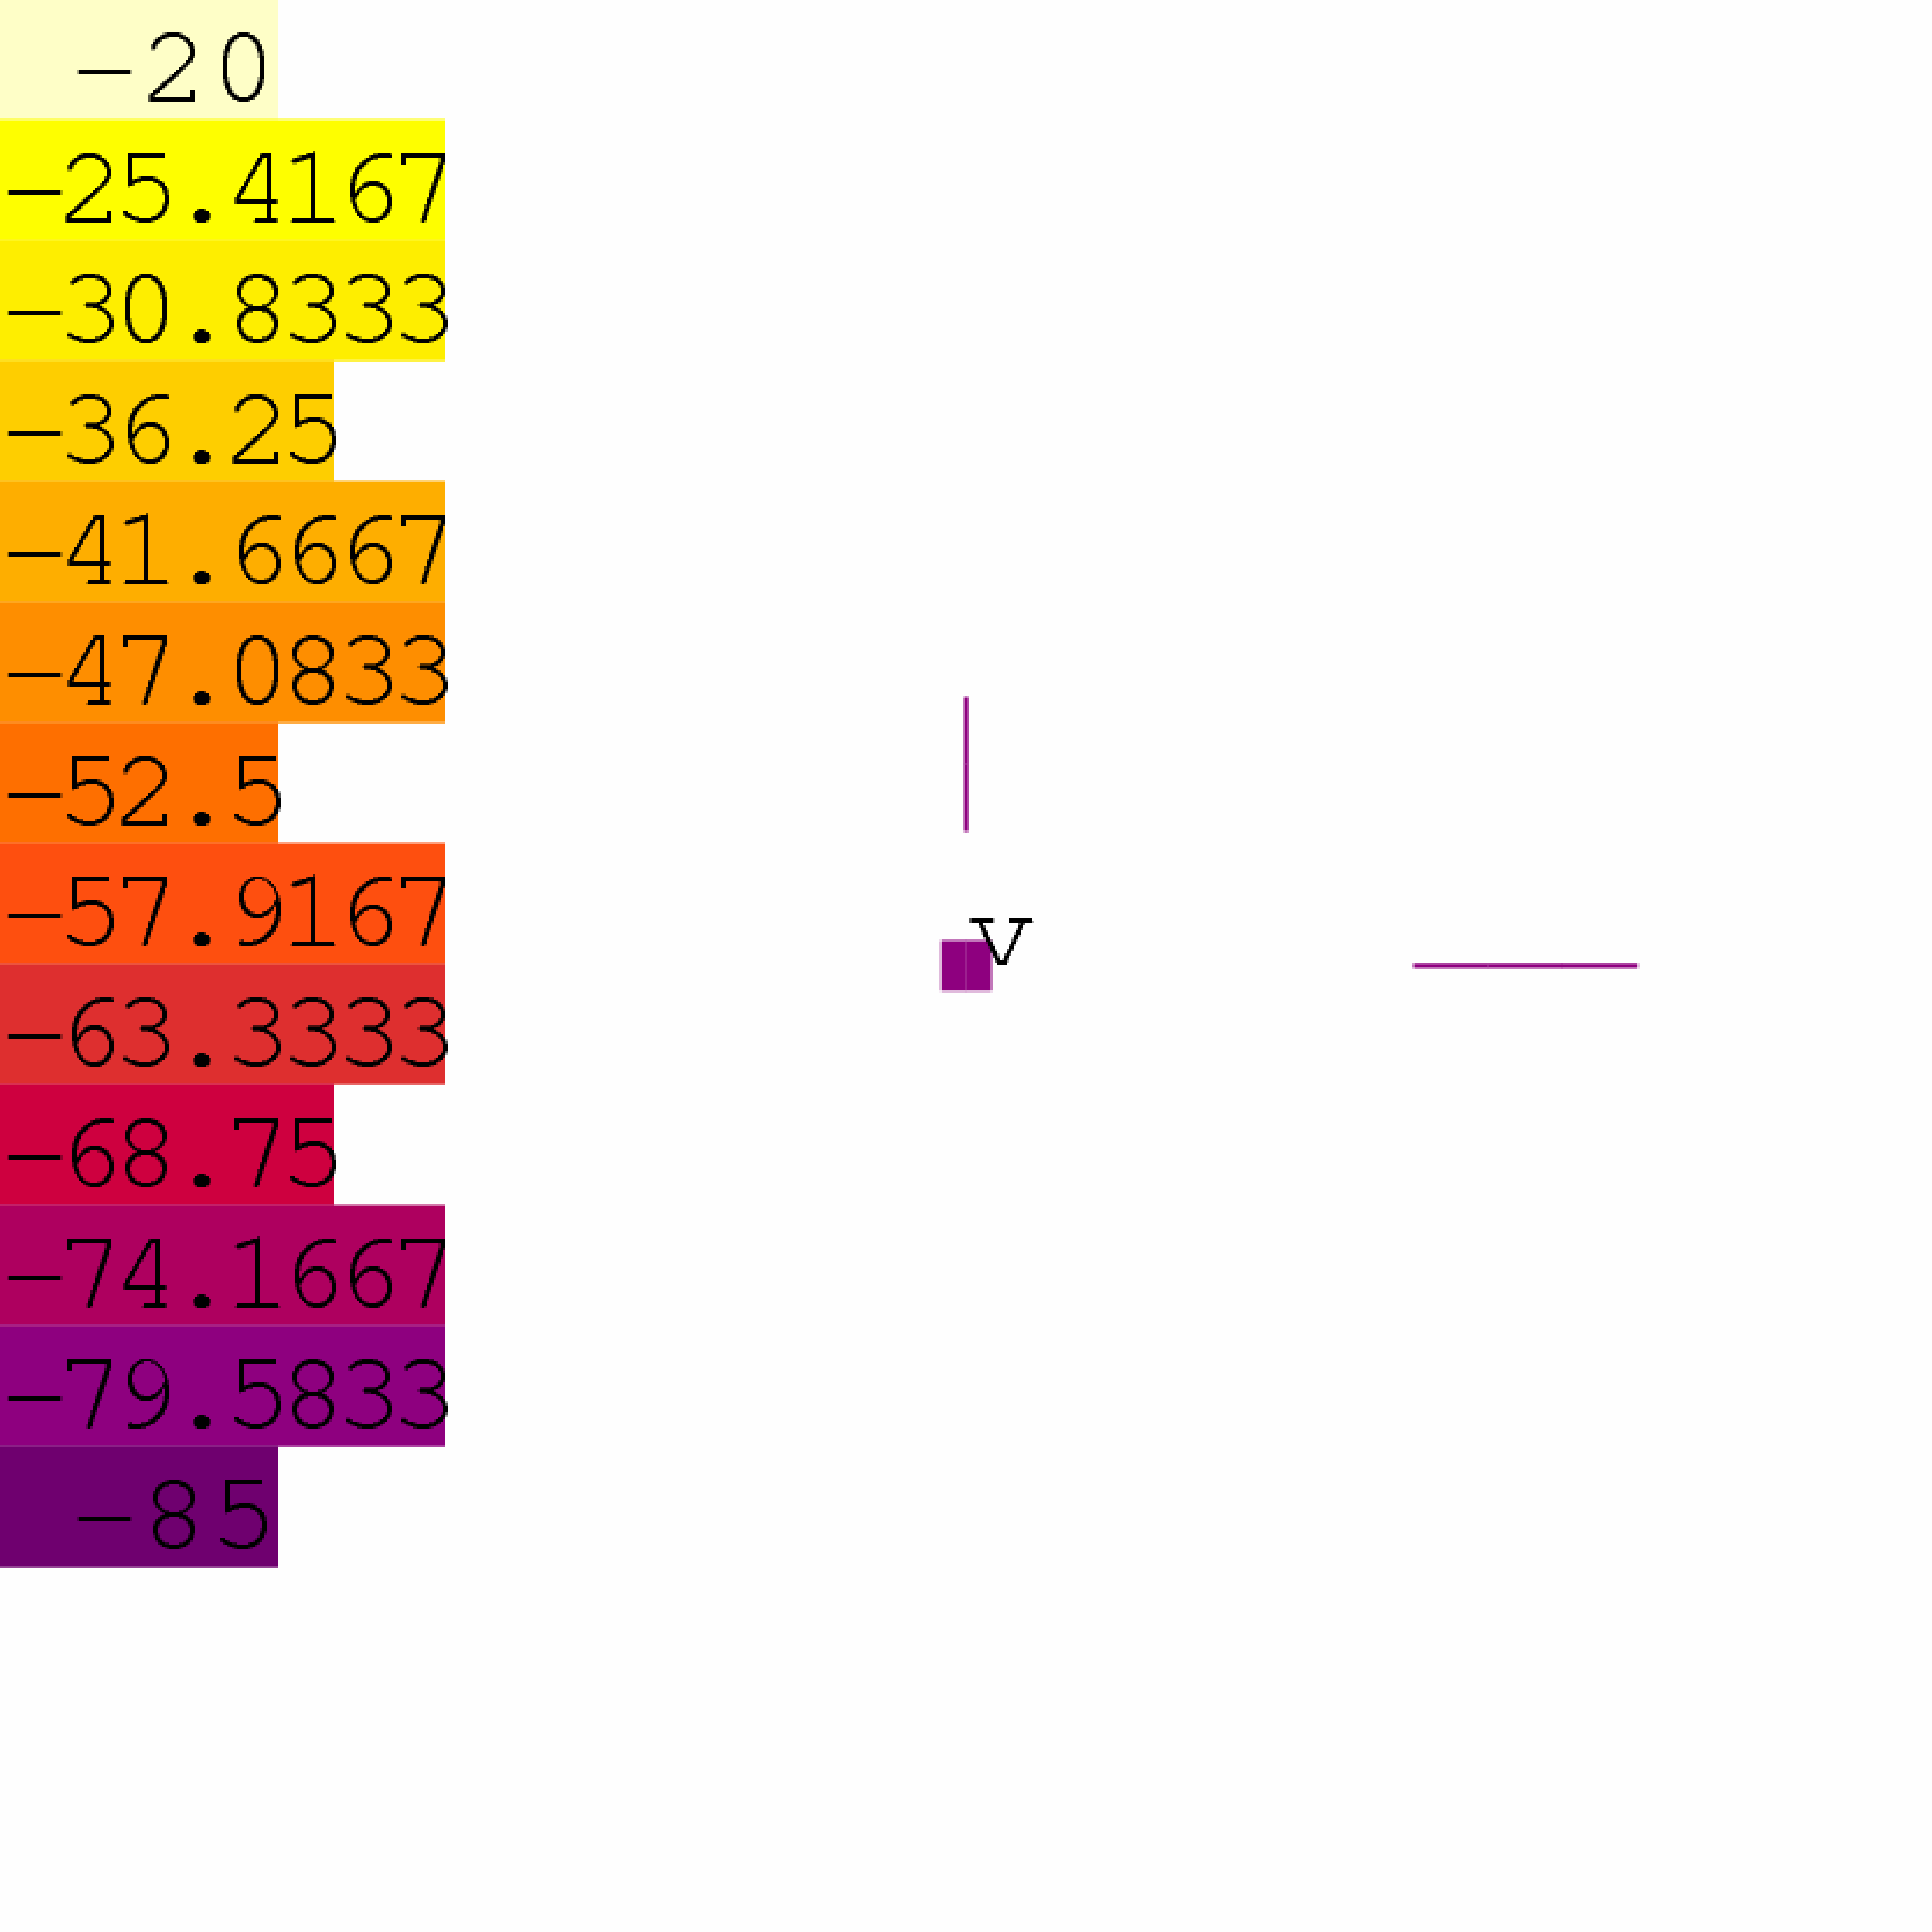

In [13]:
!convert -density 300 'fig_cylinder1.ps' -scale '300%' 'fig_cylinder1.png'
Image(filename='fig_cylinder1.png', width=300)

### branches connected to last (third) soma point

In [14]:
%%writefile m1_cylinder3.swc
1 1   0   0    0    6.1  -1
2 1   0   0    5.6  6.1   1
3 1   0   0   12.2  6.1   2
4 3 100   0    0    0.5   3
5 3 150   0    0    0.5   4
6 2   0  30    0    0.5   3
7 2   0  60    0    0.5   6

Writing m1_cylinder3.swc


**run**

In [15]:
cell_type   =   'D1'
morphology  =   'm1_cylinder3.swc'

main(   par=par,                    \
        morphology=morphology,      \
        run=0,                      \
        amp=0,                      \
        simDur=500,                 \
        stimDur=800,                \
        sim='plateau',              \
        section=5,                  \
        cell_type=cell_type,        \
        distParams=parameters[0]    )

--------------------
soma[0] len 12.1999998093
x 0.5
diam 12.1999998093
area 467.59463594
acum area 467.59463594
Ra 0.0782729240558
dist 6.09999990463
-----
--------------------
axon[0] 30.0
x 0.25
diam 1.0
area 47.1238898038
acum area 47.1238898038
Ra 14.3239448783
dist 13.5999999046
-----
x 0.75
diam 1.0
area 47.1238898038
acum area 94.2477796077
Ra 28.6478897565
dist 28.5999999046
-----
--------------------
soma 467.59463594
axon 94.2477796077


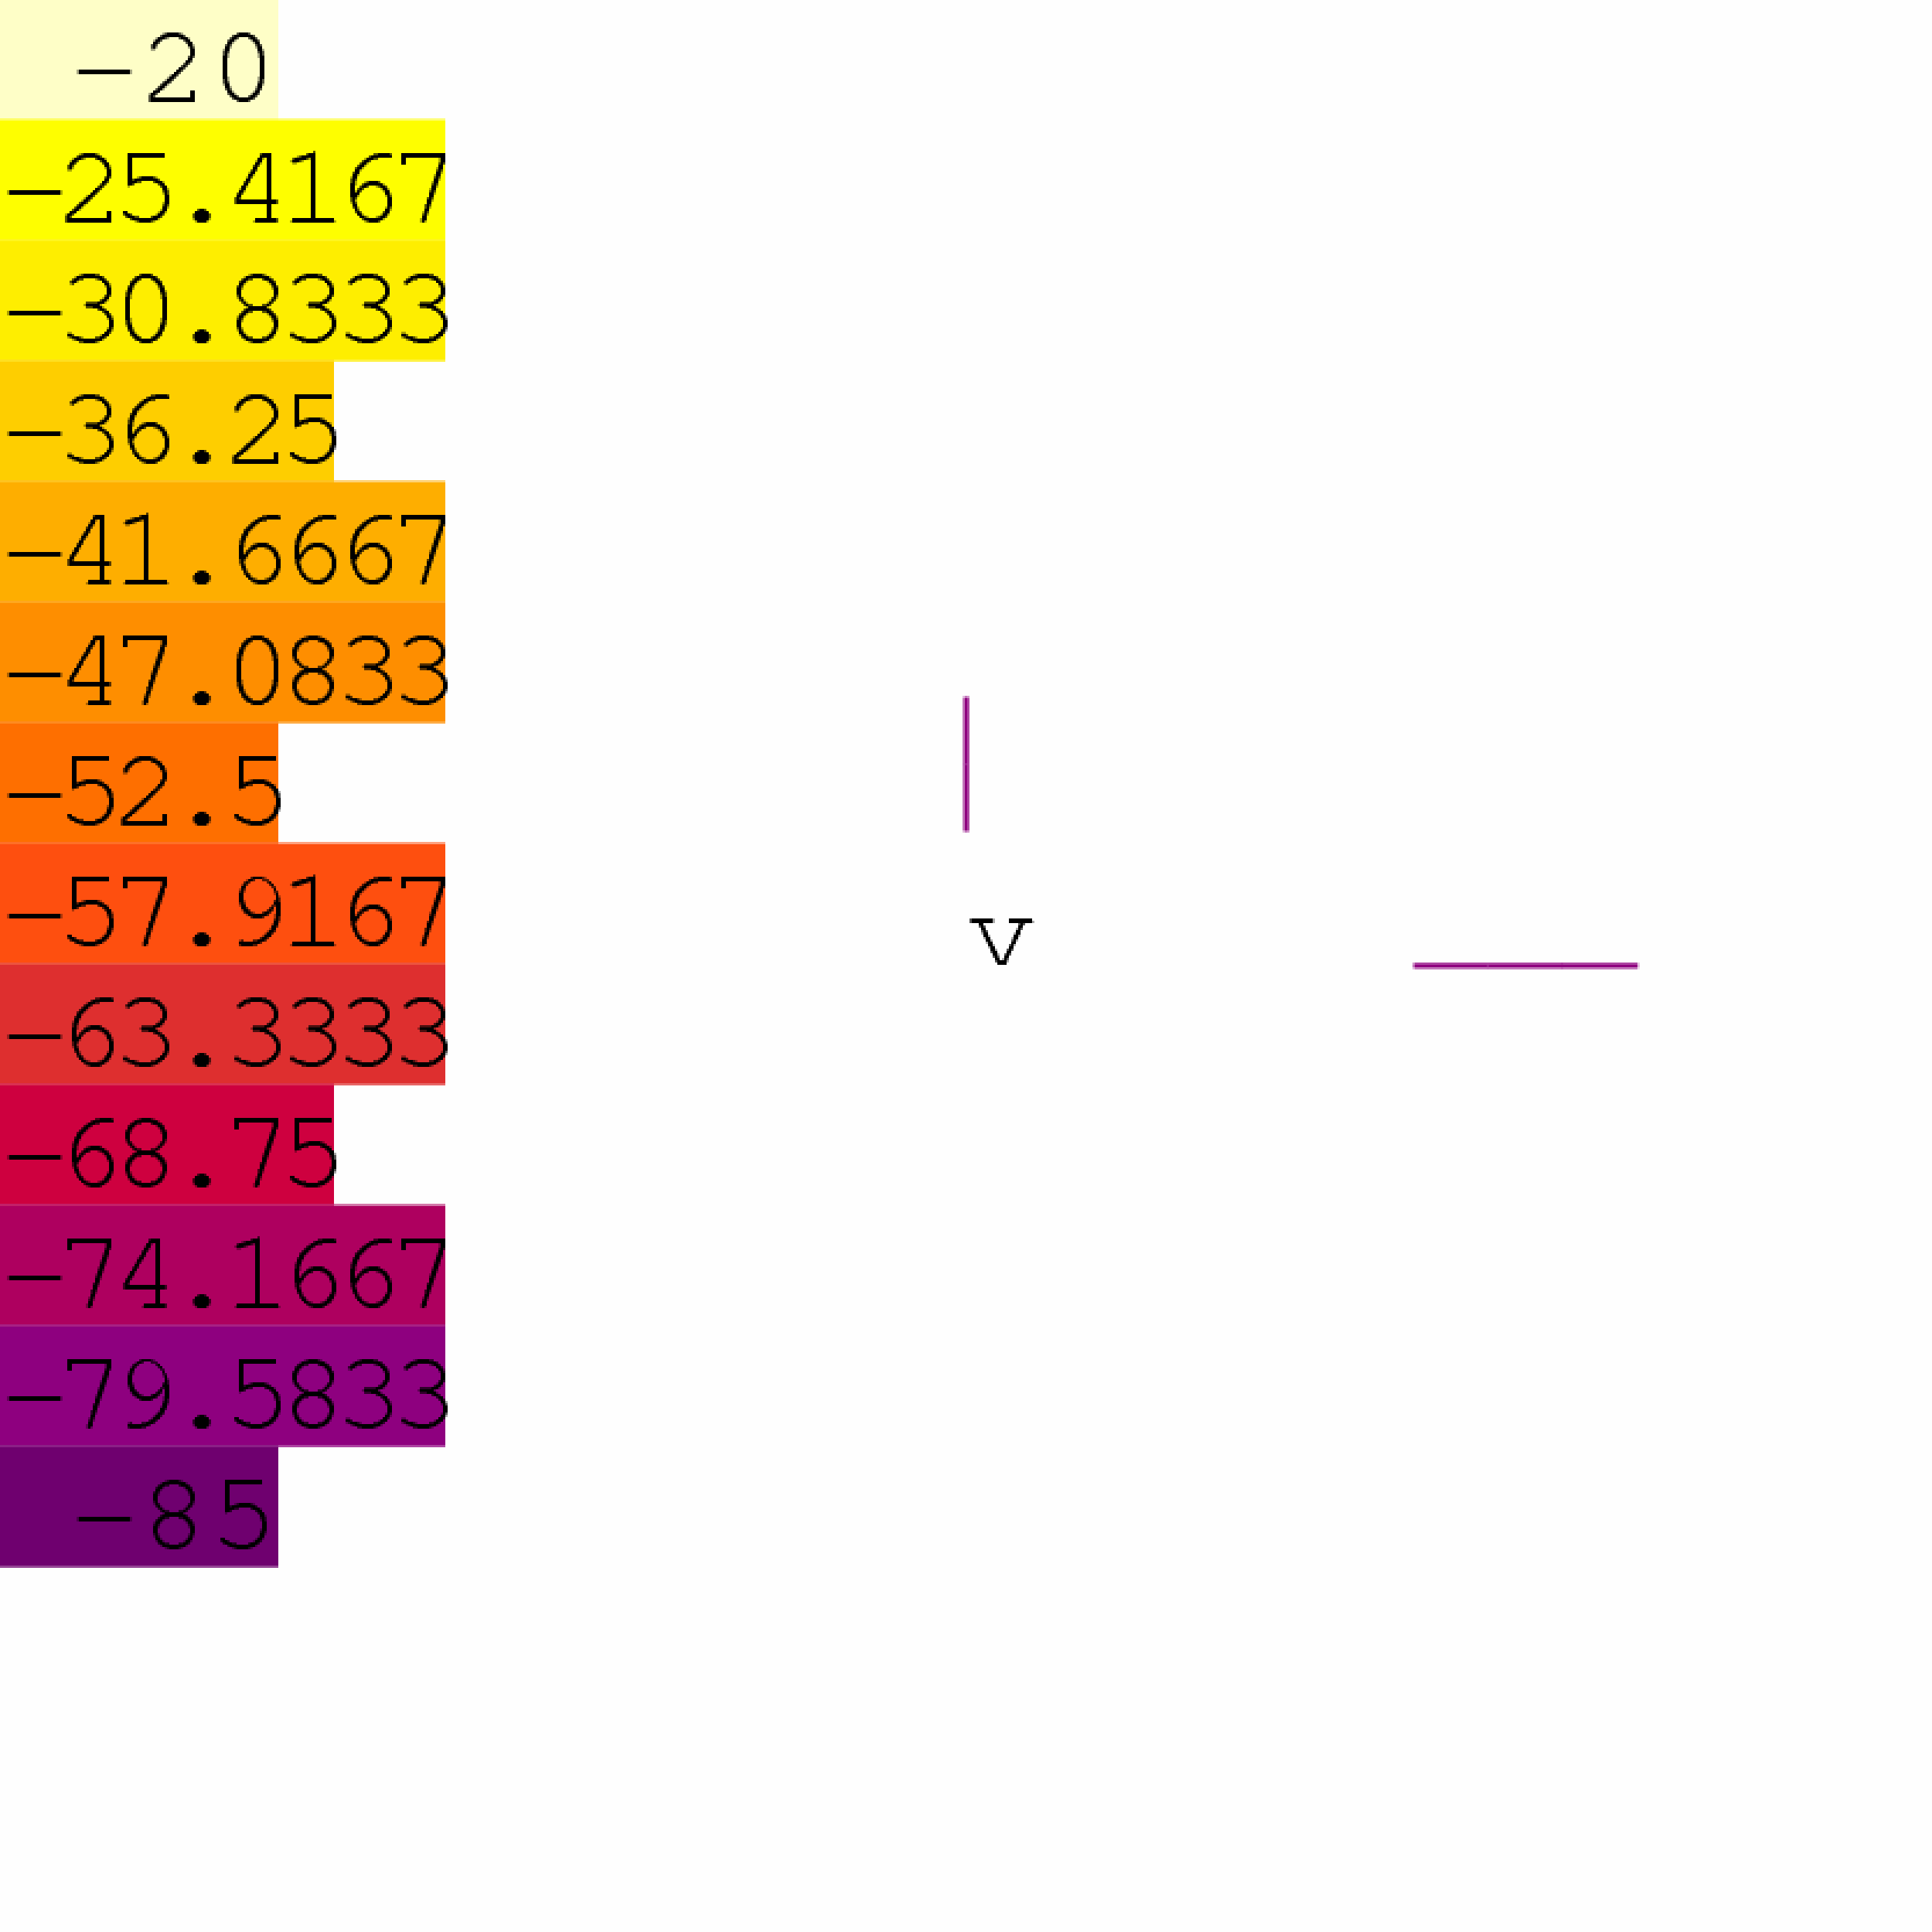

In [16]:
!convert -density 300 'fig_cylinder3.ps' -scale '300%' 'fig_cylinder3.png'
Image(filename='fig_cylinder3.png', width=300)

## somatic diameter of MSN

according to *Handbook of Basal Ganglia*, the somatic diameter of the MSN lies between 12 and 20 $\mu$m.
According to another source, <br>
**Conditional targeting of medium spiny neurons in the striatal matrix, Reinius et al., 2015** <br>
the mean diameter is 12.2; see fig below.

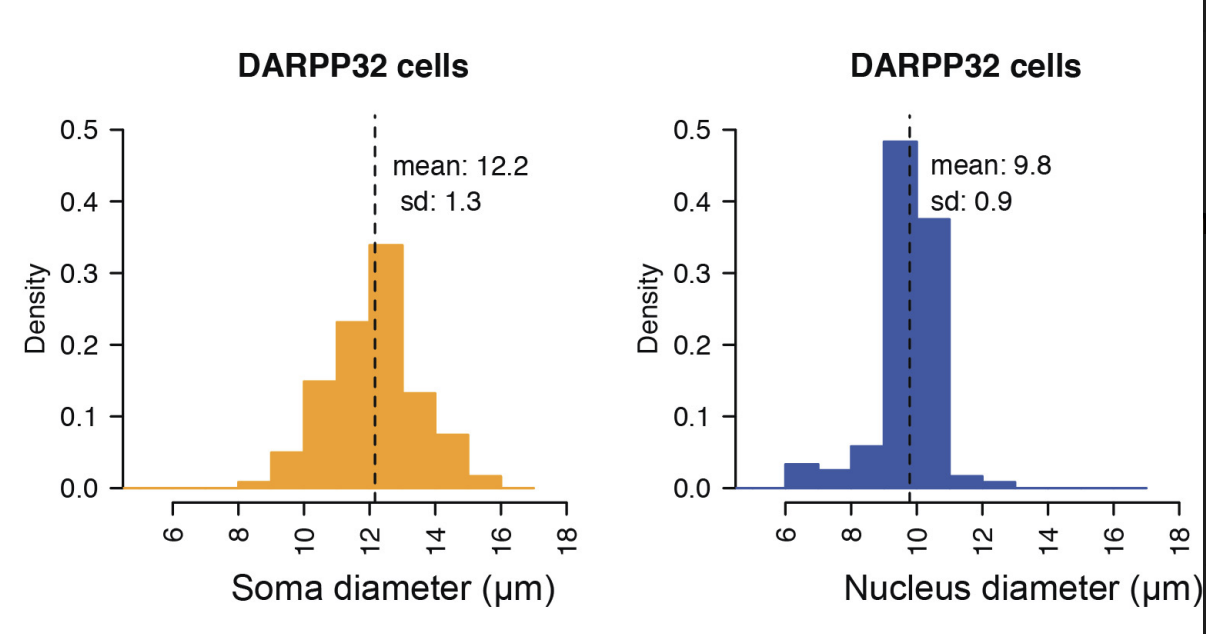

In [17]:
Image(filename='MSN_mean_soma_diam.png', width=700)

# Updating and testing new morphology

The morphologies are updated with a spherical soma (single point).
One additonal axon point were also added close to the boundary of the soma. 
This was done to make sure that the length of the axon was retined 
This is neccessary since the first point of each branch connected to the soma is interpretted  
as the soma boundary, i.e. the starting point of the axon. 
The distance from this point to the origin is not included in the length of the branch. <br>
<br>
The diameter of the soma were set to the mean value reported in the figure above (12.2), 
and the conductances of the soma were scaled by a scale factor (SF) to account for the reduced somatic area:
    
$SF = A_{org} / A_{12.2} ~= 1.34$

These changes made the updated model behaive close to identical to the original model (validation, and static modulation tested).

## Validation

Compare somatic conducances of the two models

In [32]:
cell_type   =   'D1'
morphology  =   'm1_cylinder1.swc'
somaCond    =   True

main(   morphology=morphology,      \
        sim='plateau',              \
        section=5,                  \
        cell_type=cell_type,        \
        SF=1.0,                      \
        somaCond=somaCond,          \
        distParams=parameters[0]    )

morphology  =   'm1_spherical.swc'

print('**********   SPHERICAL   ***************')

main(   morphology=morphology,      \
        sim='plateau',              \
        section=5,                  \
        cell_type=cell_type,        \
        SF=1.3394248833242937,                    \
        somaCond=somaCond,          \
        distParams=parameters[0]    )

RuntimeError: hoc error

**By checking the total somatic current for the two different shapes it is clear that a simple scale factor can adjust for the difference in surface area**

## Comparing variables of dendritic segments

In [42]:
cell_type   =   'D1'
morphology  =   'latest_WT-P270-20-14ak.swc'

main(   morphology=morphology,      \
        sim='plateau',              \
        section=5,                  \
        cell_type=cell_type,        \
        SF=1.0,                     \
        somaCond=somaCond,          \
        printDend=True,             \
        distParams=parameters[0]    )

morphology  =   '../Frontiers2018_kv42/morphology/latest_WT-P270-20-14ak.swc'


main(   morphology=morphology,      \
        sim='plateau',              \
        section=5,                  \
        cell_type=cell_type,        \
        SF=1.0,                     \
        somaCond=somaCond,          \
        printDend=True,             \
        distParams=parameters[0]    )


--------------------
soma[0] len 12.1999998093
acum ik 0.364436758971
acum ina -0.00840776791212
acum ica -1.22258821684e-05
-0.000134546855542
acum area 467.59463594
-----
--------------------
axon[0] 60.0
--------------------
soma 467.59463594
axon 0.0

total soma current
0.355882218321

--------------------
soma[0] len 12.1999998093
acum ik 0.364436758971
acum ina -0.00840776791212
acum ica -1.22258821684e-05
-0.000134546855542
acum area 467.59463594
-----
--------------------
soma[1] len 6.59999990463
acum ik 0.545430881636
acum ina -0.0125834075515
acum ica -1.82977526984e-05
-0.000201368298431
acum area 699.821157583
-----
--------------------
axon[0] 60.0
--------------------
soma 699.821157583
axon 0.0

total soma current
0.532627808034



In [43]:
!diff -y '../m_dend_new.txt' '../m_dend_org.txt'

dend[0] 0.5 8.34943133819					dend[0] 0.5 8.34943133819
dend[1] 0.166666666667 17.9811599025				dend[1] 0.166666666667 17.9811599025
dend[1] 0.5 32.7457541639					dend[1] 0.5 32.7457541639
dend[1] 0.833333333333 47.5103484253				dend[1] 0.833333333333 47.5103484253
dend[2] 0.5 69.0075470584					dend[2] 0.5 69.0075470584
dend[3] 0.0714285714286 93.7090203612				dend[3] 0.0714285714286 93.7090203612
dend[3] 0.214285714286 114.882163962				dend[3] 0.214285714286 114.882163962
dend[3] 0.357142857143 136.055307563				dend[3] 0.357142857143 136.055307563
dend[3] 0.5 157.228451164					dend[3] 0.5 157.228451164
dend[3] 0.642857142857 178.401594765				dend[3] 0.642857142857 178.401594765
dend[3] 0.785714285714 199.574738366				dend[3] 0.785714285714 199.574738366
dend[3] 0.928571428571 220.747881966				dend[3] 0.928571428571 220.747881966
dend[4] 0.0714285714286 93.8335662095				dend[4] 0.0714285714286 93.8335662095
dend[4] 0.214285714286 115.255801507				dend[4] 0.214285714286 115.255801507
de

**all the nodes are identical (checked by plotting only nodes and no distances), but the distances are of by 0.5 um.** The difference comes from the different radius used for the soma, 5.6 in the original vs 6.1 in the updated file. It seems like the soma is centered at its x,y,z coordinates and that the distance function is calculating the distance from x=1 from the boundary.

## Simulating the updated morphology
Compare to fig. 2 in Lindroos et al., 2018

starting somatic excitability simulation
all simulations done! Now plotting


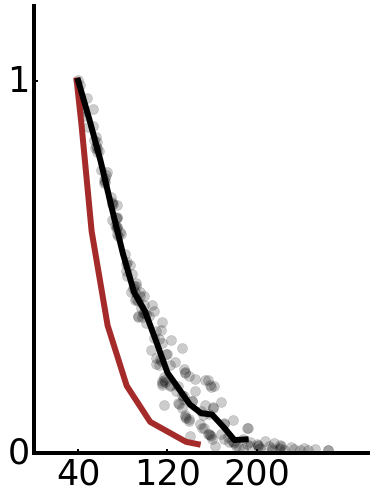

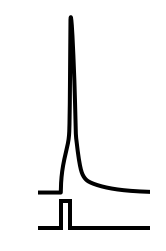

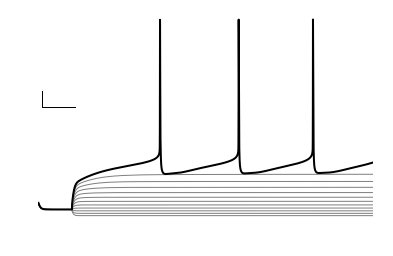

In [20]:
# %load fig2_validation.py
#
'''
MSN model used in Lindroos et al., (2018). Frontiers

Robert Lindroos (RL) <robert.lindroos at ki.se>
 
The MSN class and most channels were implemented by 
Alexander Kozlov <akozlov at kth.se>
with updates by RL

Implemented in colaboration with Kai Du <kai.du at ki.se>
'''



from __future__ import print_function, division
from neuron import h
from joblib import Parallel, delayed
import multiprocessing
import numpy                as np
import matplotlib.pyplot    as plt
import plot_functions       as fun
import MSN_builder          as build



h.load_file('stdlib.hoc')
h.load_file('import3d.hoc')


 
    
def save_vector(t, v, outfile):
    
    with open(outfile, "w") as out:
        for time, y in zip(t, v):
            out.write("%g %g\n" % (time, y))                     
 
                  


def main(   par="./params_dMSN.json",       \
                            sim='vm',       \
                            amp=0.265,      \
                            run=None,       \
                            simDur=7000,    \
                            SF=1.0,         \
                            stimDur=900     ): 
    
    
    
    # initiate cell
    cell = build.MSN(params=par, SF=SF)
    
    
    # set cascade--not connected to channels in this script, 
    # but used for setting pointers needed in the channel mechnisms
    casc    =   h.D1_reduced_cascade2_0(0.5, sec=cell.soma) 
    pointer =   casc._ref_Target1p    
       
    
    # set edge of soma as reference for dendritic distance 
    h.distance(1, sec=h.soma[0])
    
    
    # set current injection
    stim        =   h.IClamp(0.5, sec=cell.soma)
    stim.amp    =   amp  
    stim.delay  =   100
    stim.dur    =   stimDur    
     
    
    # record vectors
    tm  = h.Vector()
    tm.record(h._ref_t)
    vm  = h.Vector()
    vm.record(cell.soma(0.5)._ref_v)
    
    tstop       = simDur 
    # dt = default value; 0.025 ms (25 us)
                  
    
    # set pointers; need since same mechanisms are used for dynamic modulation of channels.
    # Modulation of channels is not used in this script
    for sec in h.allsec():
        
        for seg in sec:
            
            
            # naf and kas is in all sections
            h.setpointer(pointer, 'pka', seg.kas )
            h.setpointer(pointer, 'pka', seg.naf )
            
            if sec.name().find('axon') < 0:    
                
                
                # these channels are not in the axon section
                h.setpointer(pointer, 'pka', seg.kaf )
                h.setpointer(pointer, 'pka', seg.cal12 )
                h.setpointer(pointer, 'pka', seg.cal13 )
                h.setpointer(pointer, 'pka', seg.kir )
                
                if sec.name().find('soma') >= 0:
                    
                    
                    # N-type Ca (can) is only distributed to the soma section
                    h.setpointer(pointer, 'pka', seg.can )
            
    
    # configure simulation to record from both calcium pools.
    # the concentration is here summed, instead of averaged. 
    # This doesn't matter for the validation fig, since relative concentration is reported.
    # For Fig 5B, where concentration is reported, this is fixed when plotting.
    # -> see the plot_Ca_updated function in plot_functions.
    if sim == 'ca':
        
        for i,sec in enumerate(h.allsec()):
            
            if sec.name().find('axon') < 0: # don't record in axon
            
                for j,seg in enumerate(sec):
                    
                    sName = sec.name().split('[')[0]
                    
                    
                    # N, P/Q, R Ca pool
                    cmd = 'ca_%s%s_%s = h.Vector()' % (sName, str(i), str(j))
                    exec(cmd)
                    cmd = 'ca_%s%s_%s.record(seg._ref_cai)' % (sName, str(i), str(j))
                    exec(cmd)   
                    
                    # the L-type Ca
                    cmd = 'cal_%s%s_%s = h.Vector()' % (sName, str(i), str(j))
                    exec(cmd)
                    cmd = 'cal_%s%s_%s.record(seg._ref_cali)' % (sName, str(i), str(j))
                    exec(cmd)   
                    
                    
                    # uncomment here if testing kaf blocking effect on bAP
                    #block_fraction = 0.2
                    #gbar           = seg.kaf.gbar
                    #seg.kaf.gbar   = (1 - block_fraction) * gbar
    
    
              
    # solver------------------------------------------------------------------------------            
    cvode = h.CVode()
    
    h.finitialize(cell.v_init)
    
    # run simulation
    while h.t < tstop:
                
        h.fadvance()
        
    
    # save output ------------------------------------------------------------------------
    
    if sim == 'ca':
        
        # vm
        save_vector(tm, vm, ''.join(['Results/Ca/vm_', sim, '_', str(int(amp*1e3)), '.out']) )        
        
        # ca
        for i,sec in enumerate(h.allsec()):
        
            if sec.name().find('axon') < 0:
            
                for j,seg in enumerate(sec):
                    
                    
                    sName       =   sec.name().split('[')[0]
                    vName       =   'ca_%s%s_%s'  %  ( sName, str(i), str(j)  )
                    v2Name      =   'cal_%s%s_%s' %  ( sName, str(i), str(j)  )
                    fName       =   'Results/Ca/ca_%s_%s.out'  %  ( str(int(np.round(h.distance(seg.x)))), vName )
                    
                    cmd     = 'save_vector(tm, np.add(%s, %s), %s)' % (vName, v2Name, 'fName' ) # this is were concentrations are summed (see above)
                    
                    exec(cmd)
        
                    
    elif sim == 'vm':
        
        
        # vm
        save_vector(tm, vm, ''.join(['Results/FI/vm_', sim, '_', str(int(amp*1e3)), '.out']) )
                


# Start the simulation.
# Function needed for HBP compability  ===================================================
if __name__ == "__main__":
    
    # scale factor to compensate for decreased membrane area
    SF=1.34
    
    # dendritic validation: change in [Ca] following a bAP (validated against Day et al., 2008)
    current = 2000
    main( par="./params_dMSN.json",          \
                amp=current*1e-3,           \
                simDur=200,                 \
                stimDur=2,                  \
                SF=SF,                      \
                sim='ca'                    )
                                                
    
    print('starting somatic excitability simulation')                                               
    
    # somatic excitability (validated against FI curves in Planert et al., 2013)  
    currents    = np.arange(-100,445,40)
    num_cores   = multiprocessing.cpu_count()
    Parallel(n_jobs=num_cores)(delayed(main)(   par="./params_dMSN.json",    \
                                                amp=current*1e-3,           \
                                                run=1,                      \
                                                simDur=1000,                \
                                                SF=SF,                      \
                                                stimDur=900                 \
                        ) for current in currents)
                        
    currents    = np.arange(320,445,40)
    Parallel(n_jobs=num_cores)(delayed(main)(   par="./params_dMSN.json",    \
                                                amp=current*1e-3,           \
                                                run=1,                      \
                                                simDur=1000,                \
                                                SF=SF,                      \
                                                stimDur=900                 \
                        ) for current in currents)
                        
    
    print('all simulations done! Now plotting')
        
    # PLOTTING
    fun.plot_Ca('Results/Ca/ca*.out')
    fun.plot_vm()
    plt.show()        

        



## Static modulation (run on beskow)
Compare to fig. 4C of Lindroos et al., 2018

In [21]:
import plot_functions as fun
fun.repickle_static2('../Tuning_Frontiers_model/Reducing_soma/*', '../static_kaf_noAxon')

In [22]:
fun.plot_static_modulation_pdc('../static_kaf_noAxon')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
# clean up directory
!rm fig*
!rm m1*